# Лабораторная 8 - Классификация текстов, Фида А.Д. 6135

Dataset: https://www.kaggle.com/kazanova/sentiment140

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

## 1. Найти и загрузить любой датасет для классификации текстов

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [156]:
# nltk.download('stopwords')
# nltk.download('wordnet')

#### Load data

In [157]:
data = pd.read_table('data/training_1600000_processed_noemoticon.csv', header=None, delimiter=',', encoding = "ISO-8859-1", error_bad_lines=False)
data.columns = ['sentiment','id','date','query','special','text']
data.head()

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           special                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

### 2. Выводите в цикле целиком текст первых нескольких записей (этот этап естественно также должен быть отражён в блокноте), смотрите на тексты глазами, много думаете.

In [158]:
data.drop(['id', 'date', 'query', 'special'], axis=1, inplace=True)
df = data.sample(1000)
df['text'].values[:2]

array(['I know why the caged bird sings ',
       'ashes to ashes is comming back ... yay '], dtype=object)

### 3. Находите малоинформативные повторяющиеся участки в текстах

Базовая предобработка

In [159]:
df['Cleaned'] = df['text'].str.replace('@', '')
df['Cleaned'] = df['Cleaned'].str.replace(r'http\S+', '')
df['Cleaned'] = df['Cleaned'].str.replace('[^a-zA-Z]', ' ')

Убираем стоп слова

In [160]:
stopwords = stopwords.words('english')

In [161]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [162]:
df['Cleaned'] = df['Cleaned'].apply(lambda text : remove_stopwords(text.lower()))
df['Cleaned'] = df['Cleaned'].apply(lambda x : x.split())

In [163]:
df.head()

sentiment                                               text  \
388995          0                   I know why the caged bird sings    
806356          4            ashes to ashes is comming back ... yay    
22669           0  x_tara me tooo!! holidaysss are the best. so n...   
296001          0                      oh I feel HORRIBLE right now    
354397          0  @sillymichy that's some crazy shit. lol should...   

                                                  Cleaned  
388995                         [know, caged, bird, sings]  
806356                 [ashes, ashes, comming, back, yay]  
22669   [x, tara, tooo, holidaysss, best, looking, for...  
296001                        [oh, feel, horrible, right]  
354397  [sillymichy, crazy, shit, lol, standing, next,...

c:\users\aleksandr_fida\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


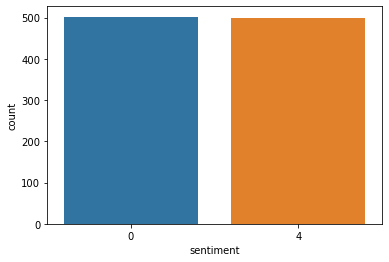

In [164]:
sns.countplot(df.sentiment);

### 4. Опциональный шаг: Проходимся по текстам стеммером

nltk.stem

In [165]:
wordnet = WordNetLemmatizer()
df['Lemmatized'] = df['Cleaned'].apply(lambda x : [wordnet.lemmatize(i) for i in x])
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x]))
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x.split()]))

In [166]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [167]:
df.head()

sentiment                                               text  \
388995          0                   I know why the caged bird sings    
806356          1            ashes to ashes is comming back ... yay    
22669           0  x_tara me tooo!! holidaysss are the best. so n...   
296001          0                      oh I feel HORRIBLE right now    
354397          0  @sillymichy that's some crazy shit. lol should...   

                                                  Cleaned  \
388995                         [know, caged, bird, sings]   
806356                 [ashes, ashes, comming, back, yay]   
22669   [x, tara, tooo, holidaysss, best, looking, for...   
296001                        [oh, feel, horrible, right]   
354397  [sillymichy, crazy, shit, lol, standing, next,...   

                                               Lemmatized  
388995                              know caged bird sings  
806356                           ash ash comming back yay  
22669     x tara tooo holiday best looking forward school  
296001                             oh feel horrible right  
354397  sillymichy crazy shit lol standing next tree t...

### 5. Создаём матрицу TfIdf с помощью TfidfVectorizer

In [169]:
tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.8,
    max_features = 2500,
    min_df = 0.002,
    use_idf = True,
    ngram_range = (1, 3)
)
z = tfidf_vectorizer.fit_transform(df['Lemmatized']).toarray()
z.shape

(1000, 1059)

### 6. Применяем sklearn.linear_model.LogisticRegression() (либо другой классификатор по вашему выбору) к получившейся матрице TfIdf, проводим классификацию (здесь и далее всё с помощью кросс-валидации!), выводим получившиеся метрики качества (accuracy для multiclass или f1 / classification_report для бинарной).

#### Fit model

In [170]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm


clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_validate(clf, z, df['sentiment'], cv=5, scoring=['f1', 'accuracy'])

In [171]:
scores

{'fit_time': array([0.76306057, 0.80562115, 0.79895234, 0.76638436, 0.75156546]),
 'score_time': array([0.18065143, 0.18444443, 0.18617368, 0.18051624, 0.18084741]),
 'test_f1': array([0.57297297, 0.66055046, 0.69767442, 0.58510638, 0.57754011]),
 'test_accuracy': array([0.605, 0.63 , 0.675, 0.61 , 0.605])}

In [172]:
y_pred = clf.fit(z[:500], df['sentiment'][:500]).predict(z[500:])
print(classification_report(df['sentiment'][500:], y_pred))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       257
           1       0.60      0.63      0.62       243

    accuracy                           0.62       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.62      0.62      0.62       500



### 7. Теперь самое интересное: оптимизация и подбор наилучших гиперпатаметров и способа предобработки текстов. Играемся с параметрами TfidfVectorizer: max_df, min_df, max_features, ngram_range ((1,2) или (1,3)), чтобы максимально повысить качество предсказаний (в качестве метрики качества для оптимизации: accuracy для многоклассовой и f1 для бинарной классификации).

#### No lemmatization

#### Gridsearch

Возьму всего 1000 экземляров из датасета, чтобы расчеты не были слишком долгими

c:\users\aleksandr_fida\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


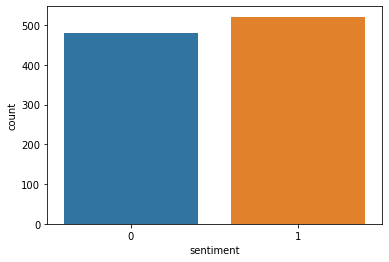

In [178]:
df = data.sample(1000)

df['Cleaned'] = df['text'].str.replace('@', '')
df['Cleaned'] = df['Cleaned'].str.replace(r'http\S+', '')
df['Cleaned'] = df['Cleaned'].str.replace('[^a-zA-Z]', ' ')

df['Cleaned'] = df['Cleaned'].apply(lambda text : remove_stopwords(text.lower()))
df['Cleaned'] = df['Cleaned'].apply(lambda x : x.split())

df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

df['Cleaned'] = df['Cleaned'].apply(lambda x : ' '.join([w for w in x]))
df['Cleaned'] = df['Cleaned'].apply(lambda x : ' '.join([w for w in x.split()]))

sns.countplot(df.sentiment);

In [179]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


grid_params = {
    'tfidf__max_df': np.arange(0.5, 1, 0.1),
    'tfidf__min_df': np.arange(0.001, 0.01, 0.001),
    'tfidf__max_features': np.arange(2000, 5000, 500),
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'svm__C': np.arange(1, 5, 1),
    'svm__kernel': ['linear', 'poly', 'rbf']
}

pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('svm', svm.SVC())
    ]
)

gs = GridSearchCV(pipe, grid_params, n_jobs=-1, cv=5, verbose=2, scoring='f1')

In [180]:
%%time
gs = gs.fit(df['Cleaned'].values, df['sentiment'])

model = gs.best_estimator_
gs.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed:  5.0

Wall time: 17min 6s


{'svm__C': 1,
 'svm__kernel': 'rbf',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 4500,
 'tfidf__min_df': 0.001,
 'tfidf__ngram_range': (1, 3)}

In [181]:
y_pred = model.predict(df['Cleaned'][500:])
print(classification_report(df['sentiment'][500:], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       242
           1       0.99      1.00      0.99       258

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



#### Lemmatization

In [182]:
wordnet = WordNetLemmatizer()
df['Lemmatized'] = df['Cleaned'].apply(lambda x: [i for i in x.split(' ')]).apply(lambda x : [wordnet.lemmatize(i) for i in x])
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x]))
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x.split()]))

In [183]:
df['Cleaned'].values[7]

'watching seven pounds smith'

In [184]:
df['Lemmatized'].values[7]

'watching seven pound smith'

In [185]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('svm', svm.SVC())
    ]
)

lemm_gs = GridSearchCV(pipe, grid_params, n_jobs=-1, cv=5, verbose=2, scoring='f1')

In [186]:
%%time
lemm_gs = lemm_gs.fit(df['Lemmatized'].values, df['sentiment'].values)

lemm_model = lemm_gs.best_estimator_
lemm_gs.best_params_

Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

Wall time: 19min 18s


{'svm__C': 1,
 'svm__kernel': 'linear',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 0.007,
 'tfidf__ngram_range': (1, 2)}

In [187]:
y_pred = lemm_model.predict(df['Cleaned'][500:])
print(classification_report(df['sentiment'][500:], y_pred))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       242
           1       0.73      0.87      0.79       258

    accuracy                           0.76       500
   macro avg       0.78      0.76      0.76       500
weighted avg       0.77      0.76      0.76       500



### 8. Подводим итоги: параметры наилучшей модели и получившиеся при них метрики классификации.

Лучшее качество модель достигла с таким набором параметров: Использование лемматизации - Нет

In [188]:
gs.best_params_

{'svm__C': 1,
 'svm__kernel': 'rbf',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 4500,
 'tfidf__min_df': 0.001,
 'tfidf__ngram_range': (1, 3)}

Метрики:

In [190]:
y_pred = model.predict(df['Cleaned'][500:])
print(classification_report(df['sentiment'][500:], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       242
           1       0.99      1.00      0.99       258

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



Конфьюжн матрикс

### 9. Строим confusion matrix

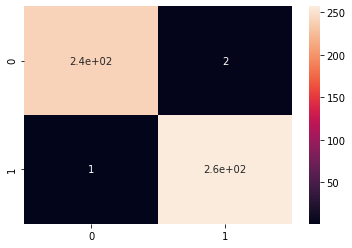

In [193]:
from sklearn.metrics import confusion_matrix


confusion_scores = confusion_matrix(df['sentiment'][500:], y_pred)
sns.heatmap(confusion_scores, annot=True);